 
# PolyPred

In this notebook, we will use PolyPred to calculate the PRS.

The installation process for PolyPred is well explained on their [GitHub Repository](https://github.com/omerwe/polyfun). PolyPred exploits fine-mapping to improve cross-population polygenic risk scores by predicting with causal effect estimates instead of tagging effect estimates.

One needs to create a separate conda environment to execute this tool. If you have already installed conda, use the following steps:

```bash
git clone https://github.com/omerwe/polyfun
cd polyfun
conda env create -f polyfun.yml
conda activate polyfun
```

The installation process is also available [here](https://github.com/omerwe/polyfun).

After installation, we followed the tutorial on GitHub for PRS calculation, which can be found [here](https://github.com/omerwe/polyfun/wiki/6.-Trans-ethnic-polygenic-risk-prediction-with-PolyPred).

You also need to download **BOLT** to calculate SNP tagging. Please refer to the BOLT Notebook for the installation process of BOLT.

### Important Notes regarding executing PolyPred

For fine mapping, PolyPred downloads the LD files from Broad Institute. The process must be executed separately for each fold and phenotype (dataset), which is time-consuming. Once the batch file of jobs is created for a specific dataset, it can be executed separately. This process can take 2-3 days to complete. The tool has two primary issues:

1. It is time-consuming, and even on HPC, sending multiple requests can slow down execution. If jobs are run for all datasets, some LD panels might be missed.
2. Although this tool optimizes the PRS score, including it in the final prediction or classification can sometimes decrease performance. The PRS score calculated by this tool should be used directly for prediction or classification.
Here's the provided content in Markdown format:

  
3. `polyfunoutput+"polypred_bash.sh"` Execute the file at the following path separately to execute the fine mapping jobs required by PolyPred for calculations. The following code snippet shows the content of the `polypred_bash.sh` file:

```python
job_file = "bash "+ polyfunoutput+'jobs.txt'

bash_script_content = f"""#!/bin/bash
#SBATCH --job-name=ttemp
#SBATCH --nodes=1
#SBATCH --partition=ascher
#SBATCH --time=200:00:00
#SBATCH --output=job.%A_%a.out
#SBATCH --error=job.%A_%a.err
#SBATCH --array=1-1

{job_file}
"""

# File name to write the content
file_name = polyfunoutput+"polypred_bash.sh"

# Write the content to the file
with open(file_name, "w") as file:
    for line in bash_script_content.split('\n'):
        file.write(line.lstrip() + '\n')
print(f"Content written to {file_name}")

#os.system("sbatch "+ file_name)
```

4. Execute the file using the following command. The path of `polyfunoutput` will be different for each phenotype and fold. For example, in the case of `SampleData1`, it was `traindirec+os.sep+"polyfun/"` or `SampleData1/Fold_0/polyfun`.

```bash
bash polyfunoutput+"polypred_bash.sh"
```
 

 

### GWAS File Processing for PolyPred

PolyPred accepts GWAS in multiple formats, and the GWAS file contains the column PolyPred requires for PRS calculation.

 


In [1]:
import os
import pandas as pd
import numpy as np
import sys

#filedirec = sys.argv[1]

filedirec = "SampleData1"
#filedirec = "asthma"
#filedirec = "irritable_bowel_syndrome"


# Check the status of the Phenotype. 
# If Phenotype is Binary, Plink requires OR, and if it continous, it requires BETAS in the GWAS file.

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"



# Read the GWAS file.
GWAS = filedirec + os.sep + filedirec+".gz"
df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")

if "BETA" in df.columns.to_list():
    # For Continous Phenotype.
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

else:
    df["BETA"] = np.log(df["OR"])
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

N = df["N"].mean()
N = int(N)
print(N)

df.to_csv(filedirec + os.sep +filedirec+".txt",sep="\t",index=False)

df.to_csv(filedirec + os.sep +filedirec+"_Plink.txt",sep="\t",index=False)

print(df.head().to_markdown())
print("Length of DataFrame!",len(df))


388028
|    |   CHR |     BP | SNP        | A1   | A2   |      N |         SE |        P |        BETA |     INFO |      MAF |
|---:|------:|-------:|:-----------|:-----|:-----|-------:|-----------:|---------:|------------:|---------:|---------:|
|  0 |     1 | 756604 | rs3131962  | A    | G    | 388028 | 0.00301666 | 0.483171 | -0.00211532 | 0.890558 | 0.36939  |
|  1 |     1 | 768448 | rs12562034 | A    | G    | 388028 | 0.00329472 | 0.834808 |  0.00068708 | 0.895894 | 0.336846 |
|  2 |     1 | 779322 | rs4040617  | G    | A    | 388028 | 0.00303344 | 0.42897  | -0.00239932 | 0.897508 | 0.377368 |
|  3 |     1 | 801536 | rs79373928 | G    | T    | 388028 | 0.00841324 | 0.808999 |  0.00203363 | 0.908963 | 0.483212 |
|  4 |     1 | 808631 | rs11240779 | G    | A    | 388028 | 0.00242821 | 0.590265 |  0.00130747 | 0.893213 | 0.45041  |
Length of DataFrame! 499617


### Define Hyperparameters

Define hyperparameters to be optimized and set initial values.

### Extract Valid SNPs from Clumped File

For Windows, download `gwak`, and for Linux, the `awk` command is sufficient. For Windows, `GWAK` is required. You can download it from [here](https://sourceforge.net/projects/gnuwin32/). Get it and place it in the same directory.


### Execution Path

At this stage, we have the genotype training data `newtrainfilename = "train_data.QC"` and genotype test data `newtestfilename = "test_data.QC"`.

We modified the following variables:

1. `filedirec = "SampleData1"` or `filedirec = sys.argv[1]`
2. `foldnumber = "0"` or `foldnumber = sys.argv[2]` for HPC.

Only these two variables can be modified to execute the code for specific data and specific folds. Though the code can be executed separately for each fold on HPC and separately for each dataset, it is recommended to execute it for multiple diseases and one fold at a time.
Here’s the corrected text in Markdown format:

 
### P-values

PRS calculation relies on P-values. SNPs with low P-values, indicating a high degree of association with a specific trait, are considered for calculation.

You can modify the code below to consider a specific set of P-values and save the file in the same format.

We considered the following parameters:

- **Minimum P-value**: `1e-10`
- **Maximum P-value**: `1.0`
- **Minimum exponent**: `10`  (Minimum P-value in exponent)
- **Number of intervals**: `100`  (Number of intervals to be considered)

The code generates an array of logarithmically spaced P-values:

```python
import numpy as np
import os

minimumpvalue = 10  # Minimum exponent for P-values
numberofintervals = 100  # Number of intervals to be considered

allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced P-values

print("Minimum P-value:", allpvalues[0])
print("Maximum P-value:", allpvalues[-1])

count = 1
with open(os.path.join(folddirec, 'range_list'), 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count += 1

pvaluefile = os.path.join(folddirec, 'range_list')
```

In this code:
- `minimumpvalue` defines the minimum exponent for P-values.
- `numberofintervals` specifies how many intervals to consider.
- `allpvalues` generates an array of P-values spaced logarithmically.
- The script writes these P-values to a file named `range_list` in the specified directory.
 

In [11]:
from operator import index
import pandas as pd
import numpy as np
import os
import subprocess
import sys
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

def create_directory(directory):
    """Function to create a directory if it doesn't exist."""
    if not os.path.exists(directory):  # Checking if the directory doesn't exist
        os.makedirs(directory)  # Creating the directory if it doesn't exist
    return directory  # Returning the created or existing directory

 
#foldnumber = sys.argv[2]
foldnumber = "0"  # Setting 'foldnumber' to "0"

folddirec = filedirec + os.sep + "Fold_" + foldnumber  # Creating a directory path for the specific fold
trainfilename = "train_data"  # Setting the name of the training data file
newtrainfilename = "train_data.QC"  # Setting the name of the new training data file

testfilename = "test_data"  # Setting the name of the test data file
newtestfilename = "test_data.QC"  # Setting the name of the new test data file

# Number of PCA to be included as a covariate.
numberofpca = ["6"]  # Setting the number of PCA components to be included

# Clumping parameters.
clump_p1 = [1]  # List containing clump parameter 'p1'
clump_r2 = [0.1]  # List containing clump parameter 'r2'
clump_kb = [200]  # List containing clump parameter 'kb'

# Pruning parameters.
p_window_size = [200]  # List containing pruning parameter 'window_size'
p_slide_size = [50]  # List containing pruning parameter 'slide_size'
p_LD_threshold = [0.25]  # List containing pruning parameter 'LD_threshold'

# Kindly note that the number of p-values to be considered varies, and the actual p-value depends on the dataset as well.
# We will specify the range list here.

minimumpvalue = 10  # Minimum p-value in exponent
numberofintervals = 20  # Number of intervals to be considered
allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced p-values

print("Minimum P-value",allpvalues[0])
print("Maximum P-value",allpvalues[-1])
print("Number of P-value",len(allpvalues))




count = 1
with open(folddirec + os.sep + 'range_list', 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count = count + 1

pvaluefile = folddirec + os.sep + 'range_list'

# Initializing an empty DataFrame with specified column names
prs_result = pd.DataFrame(columns=["clump_p1", "clump_r2", "clump_kb", "p_window_size", "p_slide_size", "p_LD_threshold",
                                   "pvalue", "numberofpca","numberofvariants","Train_pure_prs", "Train_null_model", "Train_best_model",
                                   "Test_pure_prs", "Test_null_model", "Test_best_model"])

Minimum P-value 1e-10
Maximum P-value 1.0
Number of P-value 20


### Define Helper Functions

1. **Perform Clumping and Pruning**
2. **Calculate PCA Using Plink**
3. **Fit Binary Phenotype and Save Results**
4. **Fit Continuous Phenotype and Save Results**


In [12]:
import os
import subprocess
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score


# The following function is used to perform clumping and pruing on the Genotype Data.
# It is almost the same in for all the phenotypes.

def perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    
    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)
    # First perform pruning and then clumping and the pruning.

    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--clump-p1", c1_val,
    "--extract", traindirec+os.sep+trainfilename+".prune.in",
    "--clump-r2", c2_val,
    "--clump-kb", c3_val,
    "--clump", filedirec+os.sep+filedirec+".txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", traindirec+os.sep+trainfilename
    ]    
    subprocess.run(command)

    # Extract the valid SNPs from th clumped file.
    # For windows download gwak for linux awk commmand is sufficient.
    ### For windows require GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")
    #print("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    #Linux:
    command = f"awk 'NR!=1{{print $3}}' {traindirec}{os.sep}{trainfilename}.clumped > {traindirec}{os.sep}{trainfilename}.valid.snp"
    os.system(command)
    
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+testfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+testfilename+".clumped.pruned"
    ]
    subprocess.run(command)    
    
    
# This function calculats PCA for test and train genotype data, which is then Appended with covariates, PRS, for prediction.

def calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p):
    
    # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.


    # Also extract the PCA at this point.
    # PCA are calculated afer clumping and pruining.
    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", folddirec+os.sep+testfilename
    ]
    subprocess.run(command)


    command = [
    "./plink",
        "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.        
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)

# This function used for prediction of binary phenotypes.
def fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    # One can use multiple ranges of alphas and weights for Binary Phenotype.
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    # The following transformation is required by Logit.
    phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                # Fit the null model.
                null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue
            
            # Prediction using null model on training data.
            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            # Prediction using null model on test data.
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
        
       
        
      
            # Get the PRS for a specific range.
            prs_train = pd.read_table(traindirec+os.sep+'Train_PRS_polypred.prs', sep="\s+", usecols=["FID", "IID", "PRS"])
         

            prs_train['FID'] = prs_train['FID'].astype(str)
            prs_train['IID'] = prs_train['IID'].astype(str)
           
            prs_test = pd.read_table(traindirec+os.sep+'Test_PRS_polypred.prs', sep="\s+", usecols=["FID", "IID", "PRS"])
    
            prs_test['FID'] = prs_test['FID'].astype(str)
            prs_test['IID'] = prs_test['IID'].astype(str)
            # Append PRS with covaraites and PCA for both datasets.
            pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
            pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
    
            try:
                # Fit the model.
                model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
            
            except:
                continue

            global prs_result 
            
            train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
            test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 

    
            from sklearn.metrics import roc_auc_score, confusion_matrix
            
            # Save the information for all hyperparameters.
            prs_result = prs_result._append({
                "clump_p1": c1_val,
                "clump_r2": c2_val,
                "clump_kb": c3_val,
                "p_window_size": p1_val,
                "p_slide_size": p2_val,
                "p_LD_threshold": p3_val,
                "pvalue":str(1),
                "numberofpca":p, 

                "tempalpha":str(tempalpha),
                "l1weight":str(l1weight),
                 
                 
                # Here one can use the different evaluation metrix.
                # Same goes for continous phenotype in the following function.
                "Train_pure_prs":roc_auc_score(phenotype_train["Phenotype"].values,prs_train['PRS'].values),
                "Train_null_model":roc_auc_score(phenotype_train["Phenotype"].values,train_null_predicted.values),
                "Train_best_model":roc_auc_score(phenotype_train["Phenotype"].values,train_best_predicted.values),
                
                "Test_pure_prs":roc_auc_score(phenotype_test["Phenotype"].values,prs_test['PRS'].values),
                "Test_null_model":roc_auc_score(phenotype_test["Phenotype"].values,test_null_predicted.values),
                "Test_best_model":roc_auc_score(phenotype_test["Phenotype"].values,test_best_predicted.values),
                
            }, ignore_index=True)

      
            prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

# This function used for prediction of continous phenotypes.
def fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    #phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    #phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

             
            # If explained variance is negative, use fit regualized rather than fit.
            #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
            null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
      
            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            
            
            global prs_result 
      
            prs_train = pd.read_table(traindirec+os.sep+'Train_PRS_polypred.prs', sep="\s+", usecols=["FID", "IID", "PRS"])
      

            prs_train['FID'] = prs_train['FID'].astype(str)
            prs_train['IID'] = prs_train['IID'].astype(str)
            
            
            prs_test = pd.read_table(traindirec+os.sep+'Test_PRS_polypred.prs', sep="\s+", usecols=["FID", "IID", "PRS"])
            prs_test['FID'] = prs_test['FID'].astype(str)
            prs_test['IID'] = prs_test['IID'].astype(str)
            pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
            pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
     
            #model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
            model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
      

            
            train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
            test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 

    
            from sklearn.metrics import roc_auc_score, confusion_matrix

            prs_result = prs_result._append({
                "clump_p1": c1_val,
                "clump_r2": c2_val,
                "clump_kb": c3_val,
                "p_window_size": p1_val,
                "p_slide_size": p2_val,
                "p_LD_threshold": p3_val,
              
                "numberofpca":p, 
                "pvalue":str(1),
                "tempalpha":str(tempalpha),
                "l1weight":str(l1weight),
                  

                "Train_pure_prs":explained_variance_score(phenotype_train["Phenotype"],prs_train['PRS'].values),
                "Train_null_model":explained_variance_score(phenotype_train["Phenotype"],train_null_predicted),
                "Train_best_model":explained_variance_score(phenotype_train["Phenotype"],train_best_predicted),
                
                "Test_pure_prs":explained_variance_score(phenotype_test["Phenotype"],prs_test['PRS'].values),
                "Test_null_model":explained_variance_score(phenotype_test["Phenotype"],test_null_predicted),
                "Test_best_model":explained_variance_score(phenotype_test["Phenotype"],test_best_predicted),
                
            }, ignore_index=True)

      
            prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
 
    return


## Execute PolyPred

In [13]:

# Define a global variable to store results
prs_result = pd.DataFrame()
def transform_polypred_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    ### First perform clumping on the file and save the clumpled file.
    #perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    
    #newtrainfilename = newtrainfilename+".clumped.pruned"
    #testfilename = testfilename+".clumped.pruned"
    
    
    #clupmedfile = traindirec+os.sep+newtrainfilename+".clump"
    #prunedfile = traindirec+os.sep+newtrainfilename+".clumped.pruned"

        
    # Also extract the PCA at this point for both test and training data.
    #calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p)

    #Extract p-values from the GWAS file.
    # Command for Linux.
    #os.system("awk "+"\'"+"{print $3,$8}"+"\'"+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    # Command for windows.
    ### For windows get GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"{print $3,$8}"+"\""+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")
    #print("gawk "+"\""+"{print $3,$8}"+"\""+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    #exit(0)
 
    import subprocess

    # Define the command as a list
    command = [
        'python',
        'polyfun/munge_polyfun_sumstats.py',
        '--sumstats', filedirec+os.sep+filedirec+".gz",
        '--out', traindirec+os.sep+filedirec+".temppolyfun.parquet",
    ]

    subprocess.run(command)
    
    create_directory(traindirec+os.sep+"polyfun")
    
    polyfunoutput = traindirec+os.sep+"polyfun/"
    command = [
        'python',
        'polyfun/create_finemapper_jobs.py',
        '--sumstats', traindirec+os.sep+filedirec+".temppolyfun.parquet",
        '--method', 'susie',
        '--n',str(N),
        '--non-funct',
   
        '--max-num-causal','5',
        '--allow-missing',
        
        '--out-prefix', polyfunoutput+'polyfun_output',
        '--jobs-file', polyfunoutput+'jobs.txt'
    ]
    print(" ".join(command))
    subprocess.run(command)
    
    job_file = "bash "+ polyfunoutput+'jobs.txt'
    
    bash_script_content = f"""#!/bin/bash
    #SBATCH --job-name=ttemp
    #SBATCH --nodes=1
    #SBATCH --partition=ascher
    #SBATCH --time=200:00:00
    #SBATCH --output=job.%A_%a.out
    #SBATCH --error=job.%A_%a.err
    #SBATCH --array=1-1
 
    {job_file}
    """

    # File name to write the content
    file_name = polyfunoutput+"polypred_bash.sh"

    # Write the content to the file
    with open(file_name, "w") as file:
        for line in bash_script_content.split('\n'):
            file.write(line.lstrip() + '\n')
    print(f"Content written to {file_name}")

    #os.system("sbatch "+ file_name)

    
    
    
    # Kindly note that first execute the bash file polyfunoutput+"polypred_bash.sh", and after that execute the following code. 
    command = [
        'python',
        'polyfun/aggregate_finemapper_results.py',
        '--out-prefix', polyfunoutput+'polyfun_output',
        '--sumstats', traindirec+os.sep+filedirec+".temppolyfun.parquet",
        
        # If some of the jobs, failed, use the following tag.
        '--allow-missing-jobs',
        
        '--out', traindirec+os.sep+filedirec+".finalpolypred",
        '--adjust-beta-freq'
    ]

    # Run the command
    subprocess.run(command)
    
    

    # Calculate GWAS using BOlT
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype = pd.DataFrame()
    phenotype = tempphenotype_train[[0,1,5]]
    phenotype.to_csv(traindirec+os.sep+trainfilename+".PHENO",sep="\t",header=['FID', 'IID', 'PHENO'],index=False)
 
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    print(covariate_train.head())
    print(len(covariate_train))
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    print(len(covariate_train))
 
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)    

    print(covandpcs_train)
    
    # Here ensure that the first and second column is FID and IID. For Bolt we need the covariates to start from the 
    # specific prefix like COV_X
    original_columns = covandpcs_train.columns

    # Rename columns other than 'FID' and 'IID'
    new_columns = ['FID', 'IID'] + [f'COV_{i+1}' for i in range(len(original_columns) - 2)]

    # Create a mapping of old column names to new names
    rename_mapping = dict(zip(original_columns, new_columns))

    # Rename the columns
    covandpcs_train.rename(columns=rename_mapping, inplace=True)

    # Reorder columns to ensure 'FID' and 'IID' are first
    columns = ['FID', 'IID'] + [f'COV_{i+1}' for i in range(len(original_columns) - 2)]
    covandpcs_train = covandpcs_train[columns]
    covandpcs_train.to_csv(traindirec+os.sep+trainfilename+".COV_PCA",sep="\t",index=False)    

    mm = "--lmmForceNonInf"
    
    command = [
        
    './bolt',
    '--bfile='+traindirec+os.sep+newtrainfilename+".clumped.pruned",
    '--phenoFile='+traindirec+os.sep+trainfilename+".PHENO" ,
    '--phenoCol=PHENO',
    mm,
    '--LDscoresFile=tables/LDSCORE.1000G_EUR.tab.gz',
    '--covarFile='+traindirec+os.sep+trainfilename+".COV_PCA",
    '--LDscoresMatchBp',
    #'--covarCol='+"COV_1",
    # TO include the first covariate which is sex use the following code.
    # Here i assumed that the first covariate is the sex. For our data the first covariate is sex.
    
    #
    #ERROR: Heritability estimate is close to 0; LMM may not correct confounding
    #   Instead, use PC-corrected linear/logistic regression on unrelateds
    #ERROR: Heritability estimate is close to 1; LMM may not correct confounding
    #   Instead, use PC-corrected linear/logistic regression on unrelateds
    
    #'--qCovarCol=COV_{1:'+str(len(columns)-len(columns)+1)+'}',
    
    # To include all the covariate use the following code, but not that it may crash the code as the heritability
    # from the geneotype data may reach to 0 and the BOLT-LMM may not work.
    # If heriability is close 0 or close to 1 the BOLT-LMM may not work.
    '--qCovarCol=COV_{1:'+str(len(columns)-4)+'}',
        
    
    #'--statsFile='+filedirec+os.sep+filedirec2+"."+mm.replace("-","")
    '--statsFile='+traindirec+os.sep+filedirec+"."+mm.replace("-","")+"_stat",
    #'--predBetasFile='+filedirec+os.sep+filedirec+"."+mm.replace("-","")+"_pred"
    ]
    print(" ".join(command))
    

    os.system("LD_LIBRARY_PATH=/data/ascher01/uqmmune1/miniconda3/envs/genetics/lib/ "+" ".join(command))

    command = [
        'python', 'polyfun/polypred.py',
        '--estimate-mixweights',
        '--betas', traindirec+os.sep+filedirec+"."+mm.replace("-","")+"_stat"+","+traindirec+os.sep+filedirec+".finalpolypred",
        '--pheno', traindirec+os.sep+trainfilename+".PHENO",
        '--output-prefix', traindirec+os.sep+'GWAS_polypred',
        '--plink-exe', './plink',
        traindirec+os.sep+newtrainfilename+".clumped.pruned"+".bed"
        #traindirec+os.sep+newtrainfilename+".bed"
        
    ]
    
    # Run the command
    subprocess.run(command)
    #raise
    
    command = [
         'python', 'polyfun/polypred.py',
        '--predict',
        '--betas',  traindirec+os.sep+filedirec+"."+mm.replace("-","")+"_stat"+","+traindirec+os.sep+filedirec+".finalpolypred",
        '--mixweights-prefix',  traindirec+os.sep+'GWAS_polypred',
        '--output-prefix', traindirec+os.sep+'Train_PRS_polypred',
        '--plink-exe', './plink',
        traindirec+os.sep+newtrainfilename+".clumped.pruned"+".bed"
    ]
    
    # Run the command
    subprocess.run(command)    
    
    command = [
         'python', 'polyfun/polypred.py',
        '--predict',
        '--betas',  traindirec+os.sep+filedirec+"."+mm.replace("-","")+"_stat"+","+traindirec+os.sep+filedirec+".finalpolypred",
        '--mixweights-prefix',  traindirec+os.sep+'GWAS_polypred',
        '--output-prefix', traindirec+os.sep+'Test_PRS_polypred',
        '--plink-exe', './plink',
        traindirec+os.sep+testfilename+".bed"
    ]
    
    # Run the command
    subprocess.run(command)    
    
 
    # At this stage the scores are finalizied. 
    # The next step is to fit the model 
    
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        print("Binary Phenotype!")
        fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    else:
        print("Continous Phenotype!")
        fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
            
 

 

result_directory = "PolyPred"
# Nested loops to iterate over different parameter values
# Create a directory to save the results.
create_directory(folddirec+os.sep+result_directory)
for p1_val in p_window_size:
 for p2_val in p_slide_size: 
  for p3_val in p_LD_threshold:
   for c1_val in clump_p1:
    for c2_val in clump_r2:
     for c3_val in clump_kb:
      for p in numberofpca:
        #pass
        transform_polypred_data(folddirec, newtrainfilename, p, str(p1_val), str(p2_val), str(p3_val), str(c1_val), str(c2_val), str(c3_val), result_directory, pvaluefile)


[INFO]  Reading sumstats file...
[INFO]  Done in 0.93 seconds
[INFO]  Converting OR column to log-odds
[INFO]  499617 SNPs are in the sumstats file
[INFO]  Removing 5737 HLA SNPs
[INFO]  493880 SNPs with sumstats remained after all filtering stages
[INFO]  Saving munged sumstats of 493880 SNPs to SampleData1/Fold_0/SampleData1.temppolyfun.parquet
[INFO]  Done
python polyfun/create_finemapper_jobs.py --sumstats SampleData1/Fold_0/SampleData1.temppolyfun.parquet --method susie --n 388028 --non-funct --max-num-causal 5 --allow-missing --out-prefix SampleData1/Fold_0/polyfun/polyfun_output --jobs-file SampleData1/Fold_0/polyfun/jobs.txt
[INFO]  Wrote fine-mapping commands to SampleData1/Fold_0/polyfun/jobs.txt
Content written to SampleData1/Fold_0/polyfun/polypred_bash.sh
[INFO]  Aggregating results...


632it [00:00, 2041.28it/s]

[WARNING]  output file for chromosome 1 bp 50000001-53000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 51000001-54000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 52000001-55000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 53000001-56000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 54000001-57000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 55000001-58000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 56000001-59000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 57000001-60000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 58000001-61000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 59000001-62000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 60000001-63000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 61000001-64000001 doesn't exist
[WARNING]  output file for chromosome 1 bp 62000001-65000001 doesn't exist
[WARNING]  output file fo

956it [00:00, 2470.11it/s]

[WARNING]  output file for chromosome 4 bp 130000001-133000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 131000001-134000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 132000001-135000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 133000001-136000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 134000001-137000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 135000001-138000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 136000001-139000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 137000001-140000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 138000001-141000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 139000001-142000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 140000001-143000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 141000001-144000001 doesn't exist
[WARNING]  output file for chromosome 4 bp 142000001-145000001 doesn't exist

2                          t/s]

ist
[WARNING]  output file for chromosome 11 bp 39000001-42000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 40000001-43000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 41000001-44000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 42000001-45000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 43000001-46000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 44000001-47000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 45000001-48000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 46000001-49000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 55000001-58000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 56000001-59000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 57000001-60000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 58000001-61000001 doesn't exist
[WARNING]  output file for chromosome 11 bp 59000001-62000001 doesn't exist
[WARNING

2743it [00:01, 1929.71it/s]


    Read 172070 snps
Total snps in PLINK data: Mbed = 172070

Breakdown of SNP pre-filtering results:
  172070 SNPs to include in model (i.e., GRM)
  0 additional non-GRM SNPs loaded
  0 excluded SNPs
Allocating 172070 x 380/4 bytes to store genotypes
Reading genotypes and performing QC filtering on snps and indivs...
Reading bed file #1: SampleData1/Fold_0/train_data.QC.clumped.pruned.bed
    Expecting 16346650 (+3) bytes for 380 indivs, 172070 snps


Total indivs after QC: 380
Total post-QC SNPs: M = 172070
  Variance component 1: 172070 post-QC SNPs (name: 'modelSnps')
Time for SnpData setup = 0.738851 sec

=== Reading phenotype and covariate data ===

Read data for 380 indivs (ignored 0 without genotypes) from:
  SampleData1/Fold_0/train_data.COV_PCA
Read data for 380 indivs (ignored 0 without genotypes) from:
  SampleData1/Fold_0/train_data.PHENO
Number of indivs with no missing phenotype(s) to use: 380
    Using quantitative covariate: COV_1
    Using quantitative covariate: COV_2
    Using quantitative covariate: COV_3
    Using quantitative covariate: COV_4
    Using quantitative covariate: COV_5
    Using quantitative covariate: CONST_ALL_ONES
Number of individuals used in analysis: Nused = 380
Singular values of covariate matrix:
    S[0] = 36.3836
    S[1] = 5.21992
    S[2] = 1
    S[3] = 1
    S[4] = 1
    S[5] = 0.992648
Total covariate vectors: C = 6
Total independent covariate vectors: Cindep = 6

=== Initializing Bol

NOTE: Using all-1s vector (constant term) in addition to specified covariates


Number of chroms with >= 1 good SNP: 22
Average norm of projected SNPs:           371.280532
Dimension of all-1s proj space (Nused-1): 379
Time for covariate data setup + Bolt initialization = 0.305559 sec

Phenotype 1:   N = 380   mean = 170.14   std = 0.945865

=== Computing linear regression (LINREG) stats ===

Time for computing LINREG stats = 0.0798419 sec

=== Estimating variance parameters ===

Using CGtol of 0.005 for this step
Using default number of random trials: 15 (for Nused = 380)

Estimating MC scaling f_REML at log(delta) = 1.09131, h2 = 0.25...
  Batch-solving 16 systems of equations using conjugate gradient iteration
  iter 1:  time=0.25  rNorms/orig: (0.02,0.02)  res2s: 868.646..147.756
  iter 2:  time=0.25  rNorms/orig: (0.0004,0.0005)  res2s: 869.426..147.897
  Converged at iter 2: rNorms/orig all < CGtol=0.005
  Time breakdown: dgemm = 31.7%, memory/overhead = 68.3%
  MCscaling: logDelta = 1.09, h2 = 0.250, f = -0.00114392

Estimating MC scaling f_REML at log(delt


Time for estimating chip LD Scores = 0.471238 sec

=== Reading LD Scores for calibration of Bayesian assoc stats ===

Looking up LD Scores...
  Looking for column header 'CHR': column number = 2
  Looking for column header 'BP': column number = 3
  Looking for column header 'LDSCORE': column number = 5
Found LD Scores for 171152/172070 SNPs

Estimating inflation of LINREG chisq stats using MLMe as reference...
Filtering to SNPs with chisq stats, LD Scores, and MAF > 0.01
# of SNPs passing filters before outlier removal: 171152/172070
Masking windows around outlier snps (chisq > 20.0)
# of SNPs remaining after outlier window removal: 171152/171152
Intercept of LD Score regression for ref stats:   0.998 (0.005)
Estimated attenuation: -4.747 (83.057)
Intercept of LD Score regression for cur stats: 0.999 (0.005)
Calibration factor (ref/cur) to multiply by:      0.999 (0.000)
LINREG intercept inflation = 1.0011

=== Estimating mixture parameters by cross-validation ===

Setting maximum num

NOTE: Using all-1s vector (constant term) in addition to specified covariates


Number of chroms with >= 1 good SNP: 22
Average norm of projected SNPs:           295.802788
Dimension of all-1s proj space (Nused-1): 303
  Beginning variational Bayes
  iter 1:  time=0.65 for 18 active reps
  iter 2:  time=0.47 for 18 active reps  approxLL diffs: (0.07,0.08)
  iter 3:  time=0.46 for 18 active reps  approxLL diffs: (0.00,0.00)
  Converged at iter 3: approxLL diffs each have been < LLtol=0.01
  Time breakdown: dgemm = 30.3%, memory/overhead = 69.7%
Computing predictions on left-out cross-validation fold
Time for computing predictions = 0.309486 sec

Average PVEs obtained by param pairs tested (high to low):
 f2=0.1, p=0.01: 0.000265
 f2=0.3, p=0.01: 0.000260
 f2=0.1, p=0.02: 0.000258
            ...
  f2=0.5, p=0.5: 0.000252

Detailed CV fold results:
  Absolute prediction MSE baseline (covariates only): 0.57355
  Absolute prediction MSE using standard LMM:         0.573405
  Absolute prediction MSE, fold-best f2=0.1, p=0.01:  0.573398
    Absolute pred MSE using   f2=

NOTE: Using all-1s vector (constant term) in addition to specified covariates


Number of chroms with >= 1 good SNP: 22
Average norm of projected SNPs:           295.830429
Dimension of all-1s proj space (Nused-1): 303
  Beginning variational Bayes
  iter 1:  time=0.64 for 18 active reps
  iter 2:  time=0.46 for 18 active reps  approxLL diffs: (0.07,0.07)
  iter 3:  time=0.46 for 18 active reps  approxLL diffs: (0.00,0.00)
  Converged at iter 3: approxLL diffs each have been < LLtol=0.01
  Time breakdown: dgemm = 30.2%, memory/overhead = 69.8%
Computing predictions on left-out cross-validation fold
Time for computing predictions = 0.309555 sec

Average PVEs obtained by param pairs tested (high to low):
  f2=0.5, p=0.5: -0.000038
  f2=0.3, p=0.5: -0.000038
  f2=0.5, p=0.2: -0.000038
            ...
 f2=0.1, p=0.01: -0.000043

Detailed CV fold results:
  Absolute prediction MSE baseline (covariates only): 0.873917
  Absolute prediction MSE using standard LMM:         0.874204
  Absolute prediction MSE, fold-best  f2=0.5, p=0.5:  0.874204
    Absolute pred MSE using 

NOTE: Using all-1s vector (constant term) in addition to specified covariates


Number of chroms with >= 1 good SNP: 22
Average norm of projected SNPs:           295.843895
Dimension of all-1s proj space (Nused-1): 303
  Beginning variational Bayes
  iter 1:  time=0.64 for 18 active reps
  iter 2:  time=0.47 for 18 active reps  approxLL diffs: (0.07,0.07)
  iter 3:  time=0.47 for 18 active reps  approxLL diffs: (0.00,0.00)
  Converged at iter 3: approxLL diffs each have been < LLtol=0.01
  Time breakdown: dgemm = 30.2%, memory/overhead = 69.8%
Computing predictions on left-out cross-validation fold
Time for computing predictions = 0.343775 sec

Average PVEs obtained by param pairs tested (high to low):
  f2=0.5, p=0.5: 0.000444
  f2=0.3, p=0.5: 0.000444
  f2=0.5, p=0.2: 0.000444
            ...
 f2=0.1, p=0.01: 0.000435

Detailed CV fold results:
  Absolute prediction MSE baseline (covariates only): 0.830538
  Absolute prediction MSE using standard LMM:         0.829367
  Absolute prediction MSE, fold-best  f2=0.5, p=0.5:  0.829367
    Absolute pred MSE using   f2

NOTE: Using all-1s vector (constant term) in addition to specified covariates


Number of chroms with >= 1 good SNP: 22
Average norm of projected SNPs:           295.834790
Dimension of all-1s proj space (Nused-1): 303
  Beginning variational Bayes
  iter 1:  time=0.64 for 18 active reps
  iter 2:  time=0.47 for 18 active reps  approxLL diffs: (0.07,0.07)
  iter 3:  time=0.47 for 18 active reps  approxLL diffs: (0.00,0.00)
  Converged at iter 3: approxLL diffs each have been < LLtol=0.01
  Time breakdown: dgemm = 30.2%, memory/overhead = 69.8%
Computing predictions on left-out cross-validation fold
Time for computing predictions = 0.309342 sec

Average PVEs obtained by param pairs tested (high to low):
  f2=0.5, p=0.5: 0.000576
  f2=0.3, p=0.5: 0.000576
  f2=0.5, p=0.2: 0.000576
            ...
 f2=0.1, p=0.01: 0.000561

Detailed CV fold results:
  Absolute prediction MSE baseline (covariates only): 0.74444
  Absolute prediction MSE using standard LMM:         0.743717
  Absolute prediction MSE, fold-best  f2=0.5, p=0.5:  0.743717
    Absolute pred MSE using   f2=

NOTE: Using all-1s vector (constant term) in addition to specified covariates


Number of chroms with >= 1 good SNP: 22
Average norm of projected SNPs:           295.802180
Dimension of all-1s proj space (Nused-1): 303
  Beginning variational Bayes
  iter 1:  time=0.65 for 18 active reps
  iter 2:  time=0.47 for 18 active reps  approxLL diffs: (0.07,0.08)
  iter 3:  time=0.48 for 18 active reps  approxLL diffs: (0.00,0.00)
  Converged at iter 3: approxLL diffs each have been < LLtol=0.01
  Time breakdown: dgemm = 30.0%, memory/overhead = 70.0%
Computing predictions on left-out cross-validation fold
Time for computing predictions = 0.309355 sec

Average PVEs obtained by param pairs tested (high to low):
  f2=0.5, p=0.5: 0.000587
  f2=0.3, p=0.5: 0.000587
  f2=0.5, p=0.2: 0.000587
            ...
 f2=0.1, p=0.01: 0.000571

Detailed CV fold results:
  Absolute prediction MSE baseline (covariates only): 0.548952
  Absolute prediction MSE using standard LMM:         0.548606
  Absolute prediction MSE, fold-best  f2=0.5, p=0.5:  0.548606
    Absolute pred MSE using   f2

SampleData1/Fold_0/train_data.QC.clumped.pruned.bed:   0%|          | 0/1 [00:00<?, ?it/s]

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /tmp/tmp8hzxhfr7/3kdpkmzd.log.
Options in effect:
  --allow-no-sex
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --extract /tmp/tmp8hzxhfr7/hq25porf
  --keep SampleData1/Fold_0/train_data.PHENO
  --memory 2048
  --out /tmp/tmp8hzxhfr7/3kdpkmzd
  --score /tmp/tmp8hzxhfr7/hq25porf sum
  --threads 1

63761 MB RAM detected; reserving 2048 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172070 variants remaining.
--keep: 380 people remaining.
Using 1 thread.
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778

SampleData1/Fold_0/train_data.QC.clumped.pruned.bed: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
SampleData1/Fold_0/train_data.QC.clumped.pruned.bed:   0%|          | 0/1 [00:00<?, ?it/s]

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /tmp/tmpwgtdo4fq/r8kz_iaw.log.
Options in effect:
  --allow-no-sex
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --extract /tmp/tmpwgtdo4fq/x8nfu8ab
  --keep SampleData1/Fold_0/train_data.PHENO
  --memory 2048
  --out /tmp/tmpwgtdo4fq/r8kz_iaw
  --score /tmp/tmpwgtdo4fq/x8nfu8ab sum
  --threads 1

63761 MB RAM detected; reserving 2048 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 3441 variants remaining.
--keep: 380 people remaining.
Using 1 thread.
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879

SampleData1/Fold_0/train_data.QC.clumped.pruned.bed: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


*********************************************************************
* PolyPred (POLYgenic risk PREDiction)
* Version 1.0.0
* (C) 2020-2024 Omer Weissbrod
*********************************************************************

[INFO]  Loading betas file SampleData1/Fold_0/SampleData1.lmmForceNonInf_stat...
[INFO]  done in 0.23 seconds


SampleData1/Fold_0/train_data.QC.clumped.pruned.bed:   0%|          | 0/1 [00:00<?, ?it/s]

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /tmp/tmpcss56u2y/4edirvq6.log.
Options in effect:
  --allow-no-sex
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --extract /tmp/tmpcss56u2y/i2yfjqob
  --memory 2048
  --out /tmp/tmpcss56u2y/4edirvq6
  --q-score-range /tmp/tmpcss56u2y/ranges.txt /tmp/tmpcss56u2y/cw3cappm
  --score /tmp/tmpcss56u2y/i2yfjqob sum
  --threads 1

63761 MB RAM detected; reserving 2048 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172070 variants remaining.
Using 1 thread.
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798

polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prs[scoresum_colname] = df_jk[scoresum_colname]
polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prs[scoresum_colname] = df_jk[scoresum_colname]
polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

[INFO]  Loading betas file SampleData1/Fold_0/SampleData1.finalpolypred...
[INFO]  done in 0.02 seconds
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /tmp/tmpwh1tbrly/fri346er.log.
Options in effect:
  --allow-no-sex
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --extract /tmp/tmpwh1tbrly/y1pykoe0
  --memory 2048
  --out /tmp/tmpwh1tbrly/fri346er
  --q-score-range /tmp/tmpwh1tbrly/ranges.txt /tmp/tmpwh1tbrly/xtmfed8h
  --score /tmp/tmpwh1tbrly/y1pykoe0 sum
  --threads 1

63761 MB RAM detected; reserving 2048 MB for main workspace.
172070 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 3441 variants remaining.
Using 1 thread.
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282

polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prs[scoresum_colname] = df_jk[scoresum_colname]
polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prs[scoresum_colname] = df_jk[scoresum_colname]
polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

[INFO]  Saving PRS to SampleData1/Fold_0/Train_PRS_polypred.prs

*********************************************************************
* PolyPred (POLYgenic risk PREDiction)
* Version 1.0.0
* (C) 2020-2024 Omer Weissbrod
*********************************************************************

[INFO]  Loading betas file SampleData1/Fold_0/SampleData1.lmmForceNonInf_stat...
[INFO]  done in 0.23 seconds


SampleData1/Fold_0/test_data.bed:   0%|          | 0/1 [00:00<?, ?it/s]

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /tmp/tmp5gtaxcz0/siyzl_i2.log.
Options in effect:
  --allow-no-sex
  --bfile SampleData1/Fold_0/test_data
  --extract /tmp/tmp5gtaxcz0/xe7gx0ls
  --memory 2048
  --out /tmp/tmp5gtaxcz0/siyzl_i2
  --q-score-range /tmp/tmp5gtaxcz0/ranges.txt /tmp/tmp5gtaxcz0/vby2lorq
  --score /tmp/tmp5gtaxcz0/xe7gx0ls sum
  --threads 1

63761 MB RAM detected; reserving 2048 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 172070 variants remaining.
Using 1 thread.
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919

polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prs[scoresum_colname] = df_jk[scoresum_colname]
polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prs[scoresum_colname] = df_jk[scoresum_colname]
polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

[INFO]  Loading betas file SampleData1/Fold_0/SampleData1.finalpolypred...
[INFO]  done in 0.02 seconds
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /tmp/tmpzoi6zf02/axg1dvbz.log.
Options in effect:
  --allow-no-sex
  --bfile SampleData1/Fold_0/test_data
  --extract /tmp/tmpzoi6zf02/03gdqkf_
  --memory 2048
  --out /tmp/tmpzoi6zf02/axg1dvbz
  --q-score-range /tmp/tmpzoi6zf02/ranges.txt /tmp/tmpzoi6zf02/oymevenw
  --score /tmp/tmpzoi6zf02/03gdqkf_ sum
  --threads 1

63761 MB RAM detected; reserving 2048 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 9903 variants remaining.
Using 1 thread.
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404

polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prs[scoresum_colname] = df_jk[scoresum_colname]
polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_prs[scoresum_colname] = df_jk[scoresum_colname]
polyfun/polypred.py:153: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fr

[INFO]  Saving PRS to SampleData1/Fold_0/Test_PRS_polypred.prs

Continous Phenotype!


### Repeat the process for each fold.

Change the `foldnumber` variable.

```python
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"
```

Or uncomment the following line:
```python
# foldnumber = sys.argv[1]
python PolyPred.py 0
python PolyPred.py 1
python PolyPred.py 2
python PolyPred.py 3
python PolyPred.py 4
```

The following files should exist after the execution:

1. `SampleData1/Fold_0/PolyPred/Results.csv`
2. `SampleData1/Fold_1/PolyPred/Results.csv`
3. `SampleData1/Fold_2/PolyPred/Results.csv`
4. `SampleData1/Fold_3/PolyPred/Results.csv`
5. `SampleData1/Fold_4/PolyPred/Results.csv`


### Check the results file for each fold.

In [8]:
import os

 
# List of file names to check for existence
f = [
    "./"+filedirec+"/Fold_0"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_1"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_2"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_3"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_4"+os.sep+result_directory+"Results.csv",
]

 

# Loop through each file name in the list
for loop in range(0,5):
    # Check if the file exists in the specified directory for the given fold
    if os.path.exists(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv"):
        temp = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        print("Fold_",loop, "Yes, the file exists.")
        #print(temp.head())
        print("Number of P-values processed: ",len(temp))
        # Print a message indicating that the file exists
    
    else:
        # Print a message indicating that the file does not exist
        print("Fold_",loop, "No, the file does not exist.")



Fold_ 0 Yes, the file exists.
Number of P-values processed:  1
Fold_ 1 Yes, the file exists.
Number of P-values processed:  1
Fold_ 2 No, the file does not exist.
Fold_ 3 Yes, the file exists.
Number of P-values processed:  1
Fold_ 4 Yes, the file exists.
Number of P-values processed:  1


### Sum the results for each fold.

In [9]:
print("We have to ensure when we sum the entries across all Folds, the same rows are merged!")

def sum_and_average_columns(data_frames):
    """Sum and average numerical columns across multiple DataFrames, and keep non-numerical columns unchanged."""
    # Initialize DataFrame to store the summed results for numerical columns
    summed_df = pd.DataFrame()
    non_numerical_df = pd.DataFrame()
    
    for df in data_frames:
        # Identify numerical and non-numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Sum numerical columns
        if summed_df.empty:
            summed_df = pd.DataFrame(0, index=range(len(df)), columns=numerical_cols)
        
        summed_df[numerical_cols] = summed_df[numerical_cols].add(df[numerical_cols], fill_value=0)
        
        # Keep non-numerical columns (take the first non-numerical entry for each column)
        if non_numerical_df.empty:
            non_numerical_df = df[non_numerical_cols]
        else:
            non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
    
    # Divide the summed values by the number of dataframes to get the average
    averaged_df = summed_df / len(data_frames)
    
    # Combine numerical and non-numerical DataFrames
    result_df = pd.concat([averaged_df, non_numerical_df], axis=1)
    
    return result_df

from functools import reduce

import os
import pandas as pd
from functools import reduce

def find_common_rows(allfoldsframe):
    # Define the performance columns that need to be excluded
    performance_columns = [
        'Train_null_model', 'Train_pure_prs', 'Train_best_model',
        'Test_pure_prs', 'Test_null_model', 'Test_best_model'
    ]
    important_columns = [
        'clump_p1',
        'clump_r2',
        'clump_kb',
        'p_window_size',
        'p_slide_size',
        'p_LD_threshold',
        'pvalue',
        'referencepanel',
        'PRSice-2_Model',
        'effectsizes',
        'h2model',
        
        'model',
        'numberofpca',
        'tempalpha',
        'l1weight',
         
       
    ]
    # Function to remove performance columns from a DataFrame
    def drop_performance_columns(df):
        return df.drop(columns=performance_columns, errors='ignore')
    
    def get_important_columns(df ):
        existing_columns = [col for col in important_columns if col in df.columns]
        if existing_columns:
            return df[existing_columns].copy()
        else:
            return pd.DataFrame()

    # Drop performance columns from all DataFrames in the list
    allfoldsframe_dropped = [drop_performance_columns(df) for df in allfoldsframe]
    
    # Get the important columns.
    allfoldsframe_dropped = [get_important_columns(df) for df in allfoldsframe_dropped]    
    
    # Iteratively find common rows and track unique and common rows
    common_rows = allfoldsframe_dropped[0]
    for i in range(1, len(allfoldsframe_dropped)):
        # Get the next DataFrame
        next_df = allfoldsframe_dropped[i]

        # Count unique rows in the current DataFrame and the next DataFrame
        unique_in_common = common_rows.shape[0]
        unique_in_next = next_df.shape[0]

        # Find common rows between the current common_rows and the next DataFrame
        common_rows = pd.merge(common_rows, next_df, how='inner')
    
        # Count the common rows after merging
        common_count = common_rows.shape[0]

        # Print the unique and common row counts
        print(f"Iteration {i}:")
        print(f"Unique rows in current common DataFrame: {unique_in_common}")
        print(f"Unique rows in next DataFrame: {unique_in_next}")
        print(f"Common rows after merge: {common_count}\n")
    # Now that we have the common rows, extract these from the original DataFrames
 
    extracted_common_rows_frames = []
    for original_df in allfoldsframe:
        # Merge the common rows with the original DataFrame, keeping only the rows that match the common rows
        extracted_common_rows = pd.merge(common_rows, original_df, how='inner', on=common_rows.columns.tolist())
        
        # Add the DataFrame with the extracted common rows to the list
        extracted_common_rows_frames.append(extracted_common_rows)

    # Print the number of rows in the common DataFrames
    for i, df in enumerate(extracted_common_rows_frames):
        print(f"DataFrame {i + 1} with extracted common rows has {df.shape[0]} rows.")

    # Return the list of DataFrames with extracted common rows
    return extracted_common_rows_frames



# Example usage (assuming allfoldsframe is populated as shown earlier):
allfoldsframe = []

# Loop through each file name in the list
for loop in range(0, 5):
    # Check if the file exists in the specified directory for the given fold
    file_path = os.path.join(filedirec, "Fold_" + str(loop), result_directory, "Results.csv")
    if os.path.exists(file_path):
        allfoldsframe.append(pd.read_csv(file_path))
        # Print a message indicating that the file exists
        print("Fold_", loop, "Yes, the file exists.")
    else:
        # Print a message indicating that the file does not exist
        print("Fold_", loop, "No, the file does not exist.")

# Find the common rows across all folds and return the list of extracted common rows
extracted_common_rows_list = find_common_rows(allfoldsframe)
 
# Sum the values column-wise
# For string values, do not sum it the values are going to be the same for each fold.
# Only sum the numeric values.

divided_result = sum_and_average_columns(extracted_common_rows_list)
  
print(divided_result)

 

We have to ensure when we sum the entries across all Folds, the same rows are merged!
Fold_ 0 Yes, the file exists.
Fold_ 1 Yes, the file exists.
Fold_ 2 No, the file does not exist.
Fold_ 3 Yes, the file exists.
Fold_ 4 Yes, the file exists.
Iteration 1:
Unique rows in current common DataFrame: 1
Unique rows in next DataFrame: 1
Common rows after merge: 1

Iteration 2:
Unique rows in current common DataFrame: 1
Unique rows in next DataFrame: 1
Common rows after merge: 1

Iteration 3:
Unique rows in current common DataFrame: 1
Unique rows in next DataFrame: 1
Common rows after merge: 1

DataFrame 1 with extracted common rows has 1 rows.
DataFrame 2 with extracted common rows has 1 rows.
DataFrame 3 with extracted common rows has 1 rows.
DataFrame 4 with extracted common rows has 1 rows.
   clump_p1  clump_r2  clump_kb  p_window_size  p_slide_size  p_LD_threshold  \
0       1.0       0.1     200.0          200.0          50.0            0.25   

   pvalue  numberofpca  tempalpha  l1weig

## Results

### 1. **Reporting Based on Best Training Performance:**
   - One can report the results based on the best performance of the training data. For example, if for a specific combination of hyperparameters, the training performance is high, report the corresponding test performance.
   - Example code:
     ```python
     df = divided_result.sort_values(by='Train_best_model', ascending=False)
     print(df.iloc[0].to_markdown())
     ```
 
#### Binary Phenotypes Result Analysis

You can find the performance quality for binary phenotype using the following template:

![PerformanceBinary](PerformanceBinary.PNG)
 

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range    |
|------------------------|----------|
| **Low Performance**    | 0 to 0.5 |
| **Moderate Performance** | 0.6 to 0.7 |
| **High Performance**   | 0.8 to 1 |

 
You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most phenotypes, results typically fall in the moderate train and moderate test performance category.

 
#### Continuous Phenotypes Result Analysis

You can find the performance quality for continuous phenotypes using the following template:

![PerformanceContinous](PerformanceContinous.PNG)
 
This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range        |
|------------------------|--------------|
| **Low Performance**    | 0 to 0.2     |
| **Moderate Performance** | 0.3 to 0.7 |
| **High Performance**   | 0.8 to 1     |

 

You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most continuous phenotypes, results typically fall in the moderate train and moderate test performance category.






 

### 2. **Reporting Generalized Performance:**
   - One can also report the generalized performance by calculating the difference between the training and test performance, and the sum of the test and training performance. Report the result or hyperparameter combination for which the sum is high and the difference is minimal.
   - Example code:
     ```python
     df = divided_result.copy()
     df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
     df['Sum'] = df['Train_best_model'] + df['Test_best_model']

     sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
     print(sorted_df.iloc[0].to_markdown())
     ```


### 3. **Reporting Hyperparameters Affecting Test and Train Performance:**
   - Find the hyperparameters that have more than one unique value and calculate their correlation with the following columns to understand how they are affecting the performance of train and test sets:
     - `Train_null_model`
     - `Train_pure_prs`
     - `Train_best_model`
     - `Test_pure_prs`
     - `Test_null_model`
     - `Test_best_model`



### 4. Other Analysis
1. Once you have the results, you can find how hyperparameters affect the model performance.
2. Analysis, like overfitting and underfitting, can be performed as well.
3. The way you are going to report the results can vary.
4. Results can be visualized, and other patterns in the data can be explored.


1. Reporting Based on Best Training Performance:

|                  |           0 |
|:-----------------|------------:|
| clump_p1         |   1         |
| clump_r2         |   0.1       |
| clump_kb         | 200         |
| p_window_size    | 200         |
| p_slide_size     |  50         |
| p_LD_threshold   |   0.25      |
| pvalue           |   1         |
| numberofpca      |   6         |
| tempalpha        |   0.1       |
| l1weight         |   0.1       |
| Train_pure_prs   |   0.775701  |
| Train_null_model |   0.230336  |
| Train_best_model |   0.997862  |
| Test_pure_prs    |  -0.0103224 |
| Test_null_model  |   0.110899  |
| Test_best_model  |   0.125464  |


<IPython.core.display.Javascript object>


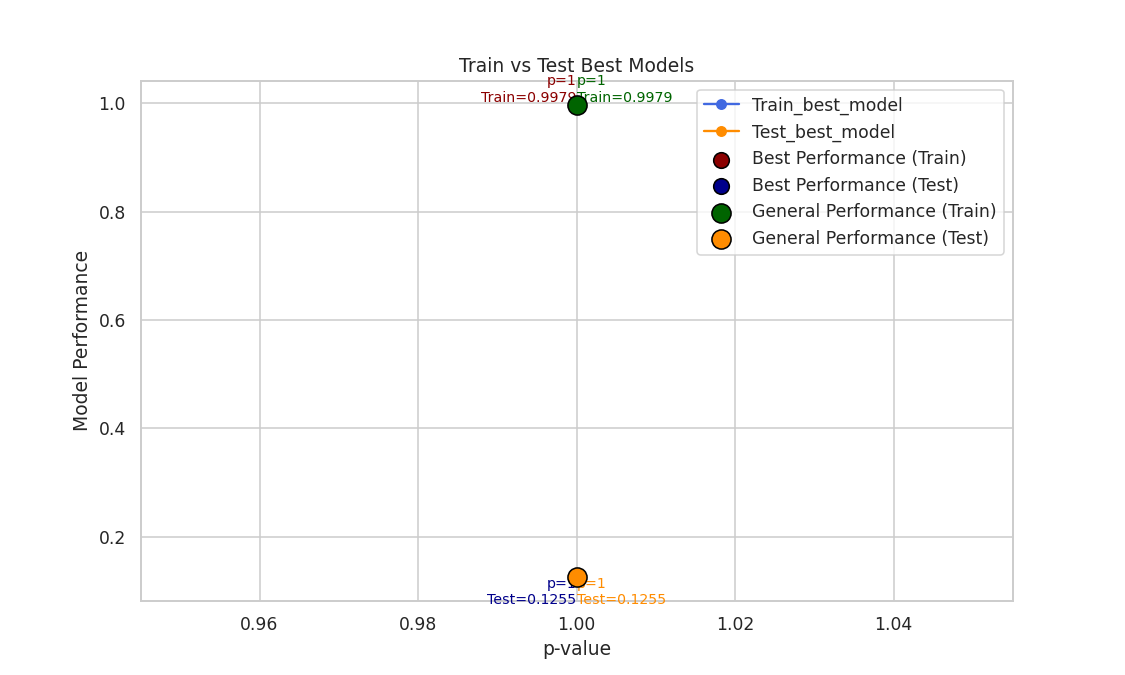

2. Reporting Generalized Performance:

|                  |           0 |
|:-----------------|------------:|
| clump_p1         |   1         |
| clump_r2         |   0.1       |
| clump_kb         | 200         |
| p_window_size    | 200         |
| p_slide_size     |  50         |
| p_LD_threshold   |   0.25      |
| pvalue           |   1         |
| numberofpca      |   6         |
| tempalpha        |   0.1       |
| l1weight         |   0.1       |
| Train_pure_prs   |   0.775701  |
| Train_null_model |   0.230336  |
| Train_best_model |   0.997862  |
| Test_pure_prs    |  -0.0103224 |
| Test_null_model  |   0.110899  |
| Test_best_model  |   0.125464  |
| Difference       |   0.872398  |
| Sum              |   1.12333   |
3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':

3. For string hyperparameters, we used one-hot encoding to find the corr

<IPython.core.display.Javascript object>


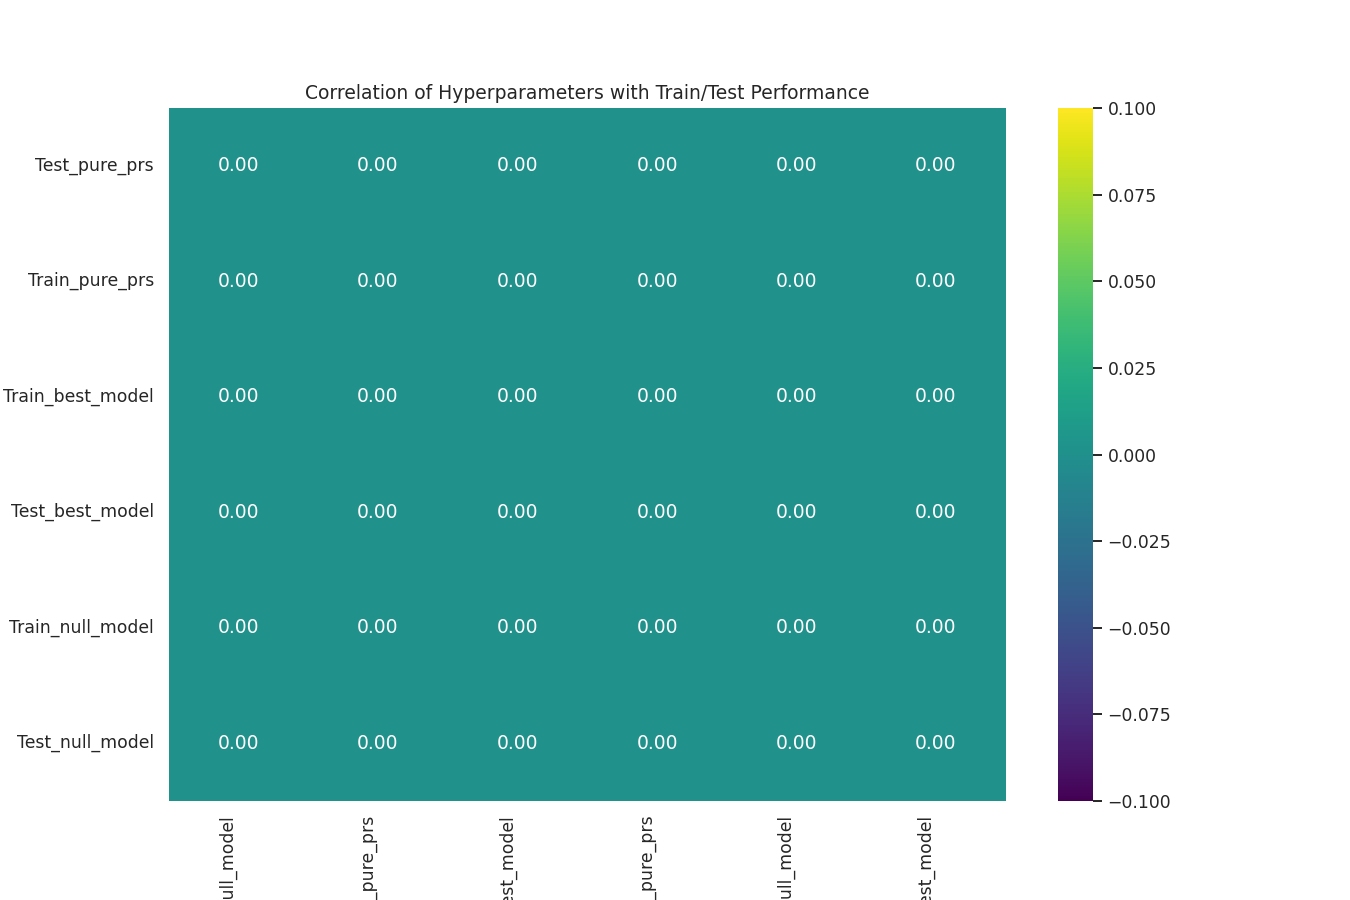

<IPython.core.display.Javascript object>

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df = divided_result.sort_values(by='Train_best_model', ascending=False)
print("1. Reporting Based on Best Training Performance:\n")
print(df.iloc[0].to_markdown())


 
df = divided_result.copy()

# Plot Train and Test best models against p-values
plt.figure(figsize=(10, 6))
plt.plot(df['pvalue'], df['Train_best_model'], label='Train_best_model', marker='o', color='royalblue')
plt.plot(df['pvalue'], df['Test_best_model'], label='Test_best_model', marker='o', color='darkorange')

# Highlight the p-value where both train and test are high
best_index = df[['Train_best_model']].sum(axis=1).idxmax()
best_pvalue = df.loc[best_index, 'pvalue']
best_train = df.loc[best_index, 'Train_best_model']
best_test = df.loc[best_index, 'Test_best_model']

# Use dark colors for the circles
plt.scatter(best_pvalue, best_train, color='darkred', s=100, label=f'Best Performance (Train)', edgecolor='black', zorder=5)
plt.scatter(best_pvalue, best_test, color='darkblue', s=100, label=f'Best Performance (Test)', edgecolor='black', zorder=5)

# Annotate the best performance with p-value, train, and test values
plt.text(best_pvalue, best_train, f'p={best_pvalue:.4g}\nTrain={best_train:.4g}', ha='right', va='bottom', fontsize=9, color='darkred')
plt.text(best_pvalue, best_test, f'p={best_pvalue:.4g}\nTest={best_test:.4g}', ha='right', va='top', fontsize=9, color='darkblue')

# Calculate Difference and Sum
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']

# Sort the DataFrame
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
#sorted_df = df.sort_values(by=[ 'Difference','Sum'], ascending=[  True,False])

# Highlight the general performance
general_index = sorted_df.index[0]
general_pvalue = sorted_df.loc[general_index, 'pvalue']
general_train = sorted_df.loc[general_index, 'Train_best_model']
general_test = sorted_df.loc[general_index, 'Test_best_model']

plt.scatter(general_pvalue, general_train, color='darkgreen', s=150, label='General Performance (Train)', edgecolor='black', zorder=6)
plt.scatter(general_pvalue, general_test, color='darkorange', s=150, label='General Performance (Test)', edgecolor='black', zorder=6)

# Annotate the general performance with p-value, train, and test values
plt.text(general_pvalue, general_train, f'p={general_pvalue:.4g}\nTrain={general_train:.4g}', ha='left', va='bottom', fontsize=9, color='darkgreen')
plt.text(general_pvalue, general_test, f'p={general_pvalue:.4g}\nTest={general_test:.4g}', ha='left', va='top', fontsize=9, color='darkorange')

# Add labels and legend
plt.xlabel('p-value')
plt.ylabel('Model Performance')
plt.title('Train vs Test Best Models')
plt.legend()
plt.show()
 




print("2. Reporting Generalized Performance:\n")
df = divided_result.copy()
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
print(sorted_df.iloc[0].to_markdown())


print("3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':\n")

print("3. For string hyperparameters, we used one-hot encoding to find the correlation between string hyperparameters and 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model'.")

print("3. We performed this analysis for those hyperparameters that have more than one unique value.")

correlation_columns = [
 'Train_null_model', 'Train_pure_prs', 'Train_best_model',
 'Test_pure_prs', 'Test_null_model', 'Test_best_model'
]

hyperparams = [col for col in divided_result.columns if len(divided_result[col].unique()) > 1]
hyperparams = list(set(hyperparams+correlation_columns))
 
# Separate numeric and string columns
numeric_hyperparams = [col for col in hyperparams if pd.api.types.is_numeric_dtype(divided_result[col])]
string_hyperparams = [col for col in hyperparams if pd.api.types.is_string_dtype(divided_result[col])]


# Encode string columns using one-hot encoding
divided_result_encoded = pd.get_dummies(divided_result, columns=string_hyperparams)

# Combine numeric hyperparams with the new one-hot encoded columns
encoded_columns = [col for col in divided_result_encoded.columns if col.startswith(tuple(string_hyperparams))]
hyperparams = numeric_hyperparams + encoded_columns
 

# Calculate correlations
correlations = divided_result_encoded[hyperparams].corr()
 
# Display correlation of hyperparameters with train/test performance columns
hyperparam_correlations = correlations.loc[hyperparams, correlation_columns]
 
hyperparam_correlations = hyperparam_correlations.fillna(0)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(hyperparam_correlations, annot=True, cmap='viridis', fmt='.2f', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Rotate y-axis labels to horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

plt.title('Correlation of Hyperparameters with Train/Test Performance')
plt.show() 

sns.set_theme(style="whitegrid")  # Choose your preferred style
pairplot = sns.pairplot(divided_result_encoded[hyperparams],hue = 'Test_best_model', palette='viridis')

# Adjust the figure size
pairplot.fig.set_size_inches(15, 15)  # You can adjust the size as needed

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, ha='right')  # X-axis labels vertical
    #ax.set_ylabel(ax.get_ylabel(), rotation=0, va='bottom')  # Y-axis labels horizontal

# Show the plot
plt.show()


